# **Importing Packages**

In [ ]:
!pip install scikeras
!pip install lime
!pip install pdpbox
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, SMOTEN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, recall_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.metrics import Recall
from keras.callbacks import EarlyStopping

from sklearn.inspection import permutation_importance
from pdpbox.pdp import pdp_plot, pdp_isolate
import shap
from lime.lime_tabular import LimeTabularExplainer

# **Loading Data + Train-Test Split**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/lohdaijiu/BT4012/main/Model_Data.csv")
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [ ]:
X = df.drop(columns = ["FraudFound_P"])

y = df['FraudFound_P']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# oversampling + undersampling

over = RandomOverSampler(sampling_strategy = 0.2)
x_train_1, y_train_1 = over.fit_resample(X_train, y_train)
under = RandomUnderSampler(sampling_strategy = 1)
x_train_1, y_train_1 = under.fit_resample(x_train_1, y_train_1)

In [ ]:
# checking class ratio

y_train_1.sum()/len(y_train_1)

0.5

# **Naive Bayes Classifier**

Note: This uses original train-test split, no resampling.

In [ ]:
# use Naive Bayes classifier with original train-test data

g = GaussianNB()
g.fit(X_train, y_train)
base_pred = g.predict(X_test)
print(classification_report(y_test, base_pred))
print(roc_auc_score(y_test, base_pred))

              precision    recall  f1-score   support

           0       0.98      0.63      0.77      4780
           1       0.13      0.85      0.22       309

    accuracy                           0.64      5089
   macro avg       0.56      0.74      0.49      5089
weighted avg       0.93      0.64      0.73      5089

0.7378603539559383


# **Logistic Regression**

After running Logistic Regression on original train-test split, we realised the class imbalance caused the model to heavily favour the majority class.

As such, we used a combination of over and undersampling to the training data. Running a LR model on the new data, we achieved better results.

In [ ]:
# logistic regression on original data

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
print(roc_auc_score(y_test, lr_pred))

[[4778    2]
 [ 309    0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4780
           1       0.00      0.00      0.00       309

    accuracy                           0.94      5089
   macro avg       0.47      0.50      0.48      5089
weighted avg       0.88      0.94      0.91      5089

0.4997907949790795


In [ ]:
lr = LogisticRegression(max_iter = 500)
lr.fit(x_train_1, y_train_1)
lr_pred = lr.predict(X_test)
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

[[3046 1734]
 [  43  266]]
              precision    recall  f1-score   support

           0       0.99      0.64      0.77      4780
           1       0.13      0.86      0.23       309

    accuracy                           0.65      5089
   macro avg       0.56      0.75      0.50      5089
weighted avg       0.93      0.65      0.74      5089



We tune the LR model to try to achieve better results.

In [ ]:
weights = np.linspace(0.0,0.99,200)
lr = LogisticRegression(max_iter=500)

param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}


gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(5), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(x_train_1, y_train_1)
print(gridsearch.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'class_weight': {0: 0.23879396984924622, 1: 0.7612060301507537}}


In [ ]:
lr = LogisticRegression(class_weight = {0: 0.23879396984924622, 1: 0.7612060301507537}, max_iter = 500)
lr.fit(x_train_1, y_train_1)
lr_pred = lr.predict(X_test)
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
print(roc_auc_score(y_test, lr_pred))

[[2544 2236]
 [   9  300]]
              precision    recall  f1-score   support

           0       1.00      0.53      0.69      4780
           1       0.12      0.97      0.21       309

    accuracy                           0.56      5089
   macro avg       0.56      0.75      0.45      5089
weighted avg       0.94      0.56      0.66      5089

0.7515456798147622


# **Decision Tree**

We implemented DT vs RF to compare the performance between single classifier and ensemble.

In [ ]:
dt = DecisionTreeClassifier(min_samples_leaf = 0.005, ccp_alpha = 0.001)
dt.fit(x_train_1, y_train_1)
y_pred = dt.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

# tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_pred), labels=[0, 1]).ravel()
# print('True Positives: ', tp)
# print('True Negatives: ', tn)
# print('False Positives: ', fp)
# print('False Negatives: ', fn)

[[3280 1500]
 [  85  224]]
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      4780
           1       0.13      0.72      0.22       309

    accuracy                           0.69      5089
   macro avg       0.55      0.71      0.51      5089
weighted avg       0.92      0.69      0.77      5089

0.7055557812351898


# **Random Forest**

We implemented RandomizedSearchCV here. Compared to untuned model, we got better results.

In [ ]:
# Random Forest model on original data

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

[[4779    1]
 [ 308    1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4780
           1       0.50      0.00      0.01       309

    accuracy                           0.94      5089
   macro avg       0.72      0.50      0.49      5089
weighted avg       0.91      0.94      0.91      5089

0.5015135204668861


In [ ]:
# baseline Random Forest model

rf = RandomForestClassifier()
rf.fit(x_train_1, y_train_1)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4119  661]
 [ 181  128]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      4780
           1       0.16      0.41      0.23       309

    accuracy                           0.83      5089
   macro avg       0.56      0.64      0.57      5089
weighted avg       0.91      0.83      0.87      5089



In [ ]:
# RandomizedSearchCV for Random Forest

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [20, 50, 100, 150]
min_samples_leaf = [20, 50, 100, 150]
bootstrap = [True, False]
ccp = [0.0001, 0.001, 0.01]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp}

In [ ]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, scoring = 'recall', verbose=2, random_state=20, n_jobs = -1)
rf_random.fit(x_train_1, y_train_1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0001, 0.001, 0.01],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [20, 50, 100, 150],
                                        'min_samples_split': [20, 50, 100, 150],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=20, scoring='recall', verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 322,
 'min_samples_split': 150,
 'min_samples_leaf': 20,
 'max_features': 'auto',
 'max_depth': 20,
 'ccp_alpha': 0.001,
 'bootstrap': False}

In [ ]:
# Fit the random search model
rf = RandomForestClassifier(n_estimators = 322, 
                            min_samples_split = 150, 
                            min_samples_leaf = 20, 
                            max_features = 'auto', 
                            max_depth = 20,
                            ccp_alpha = 0.001)
rf.fit(x_train_1, y_train_1)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

[[2786 1994]
 [  15  294]]
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      4780
           1       0.13      0.95      0.23       309

    accuracy                           0.61      5089
   macro avg       0.56      0.77      0.48      5089
weighted avg       0.94      0.61      0.70      5089

0.7671507494820652


# **XGBoost**

We implement XGB to compare bagging (RF) and boosting (XGB). RF performs better.

In [ ]:
xgb = XGBClassifier(min_split_loss = 0.1, max_depth = 5, reg_alpha = 0.01)
xgb.fit(x_train_1, y_train_1)
xgb_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
print(roc_auc_score(y_test, xgb_pred))

[[3430 1350]
 [  85  224]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      4780
           1       0.14      0.72      0.24       309

    accuracy                           0.72      5089
   macro avg       0.56      0.72      0.53      5089
weighted avg       0.93      0.72      0.79      5089

0.7212461578042274


# **VotingClassifier**

Doesn't perform as well as individual model.

In [ ]:
vc = VotingClassifier(estimators = [('rf', rf), ('xgb', xgb)], voting = 'hard')
# vc = VotingClassifier(estimators = [('lr', lr), ('dt', dt)], voting = 'hard')
vc.fit(x_train_1, y_train_1)
vc_pred = vc.predict(X_test)
print(confusion_matrix(y_test, vc_pred))
print(classification_report(y_test, vc_pred))
print(roc_auc_score(y_test, vc_pred))

[[3451 1329]
 [  86  223]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      4780
           1       0.14      0.72      0.24       309

    accuracy                           0.72      5089
   macro avg       0.56      0.72      0.53      5089
weighted avg       0.93      0.72      0.79      5089

0.7218246875465464


# **Neural Network**

We used a variety of methods such as varying activation functions, number of hidden layers, adding dropout, early stopping to improve performance of NN. This is the optimized model.

In [ ]:
model1 = Sequential()
model1.add(Dense(5, activation='relu', input_shape=(76,)))
model1.add(Dense(10, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Recall()])

# use earlystopping
callback = EarlyStopping(monitor='loss', patience=3)
model1.fit(x_train_1, y_train_1, epochs=100, batch_size=10, callbacks = [callback], verbose=0)

y_pred1 = model1.predict(X_test)

print(confusion_matrix(y_test, y_pred1>0.5))
print(classification_report(y_test, y_pred1>0.5))
print(roc_auc_score(y_test, y_pred>0.5))

160/160 [==============================] - 0s 1ms/step
[[3057 1723]
 [  52  257]]
              precision    recall  f1-score   support

           0       0.98      0.64      0.78      4780
           1       0.13      0.83      0.22       309

    accuracy                           0.65      5089
   macro avg       0.56      0.74      0.50      5089
weighted avg       0.93      0.65      0.74      5089

0.7652188189733382


# **Conclusion**

All our models heavily favour recall but sacrifice precision for the positive class. However, as our model's main aim is to flag out potential fraud cases for human intervention/involvement, it is more important for us to maximise true positive than minimise false positive.

# **RF Feature Importance**

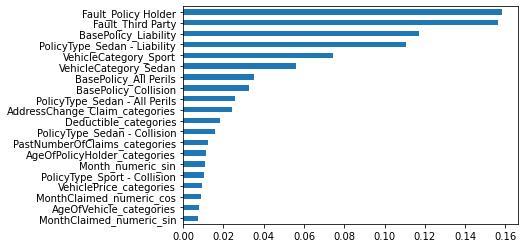

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances.nlargest(20)[::-1].plot(kind='barh')

From the MDI feature importance plot, the most important features are `Fault_Policy Holder`, `Fault_Third Party`, and `BasePolicy_Liability`. We will compare this with Permutation Importance.

In [ ]:
# result = permutation_importance(
#     rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()
# sorted_importances_idx = sorted_importances_idx[-10:]
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=X.columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

# **PDP**

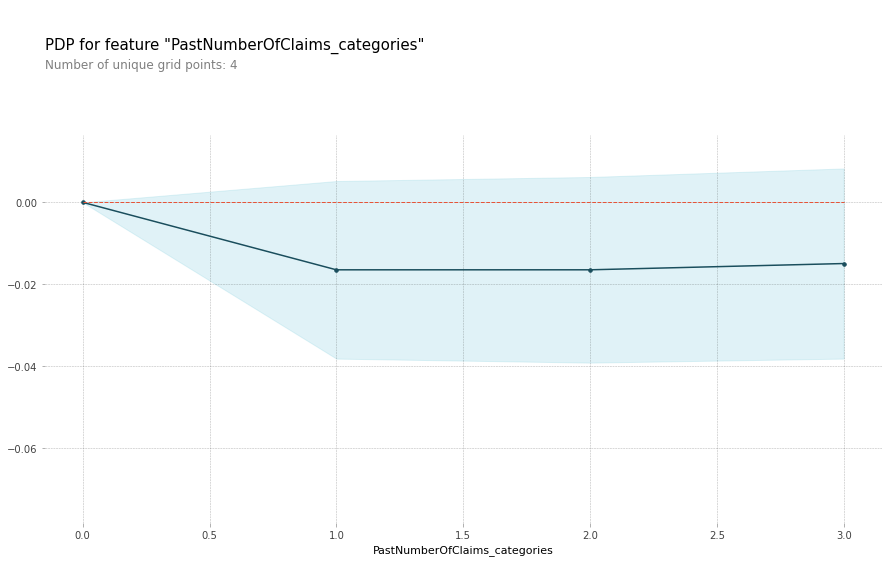

In [ ]:
features = [c for c in X_test.columns]

pdp_1 = pdp_isolate(model=rf, dataset=X_test, model_features=features, feature='PastNumberOfClaims_categories')
fig, axes = pdp_plot(pdp_isolate_out=pdp_1, feature_name='PastNumberOfClaims_categories')

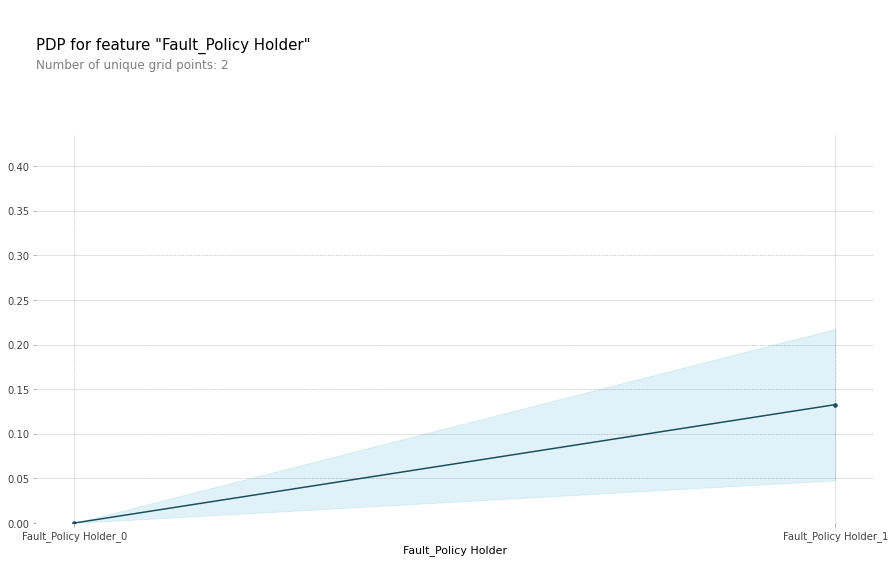

In [ ]:
pdp_1 = pdp_isolate(model=rf, dataset=X_test, model_features=features, feature='Fault_Policy Holder')
fig, axes = pdp_plot(pdp_isolate_out=pdp_1, feature_name='Fault_Policy Holder')

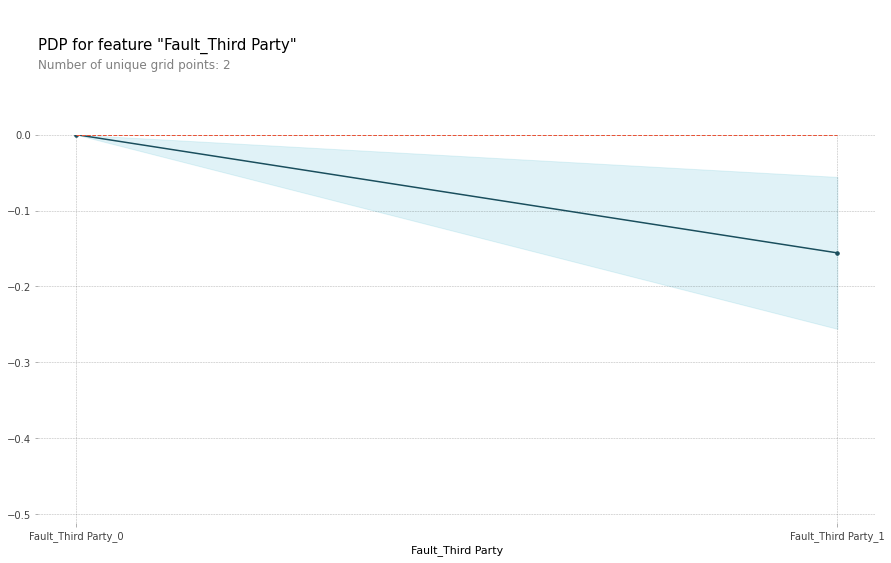

In [ ]:
pdp_1 = pdp_isolate(model=rf, dataset=X_test, model_features=features, feature='Fault_Third Party')
fig, axes = pdp_plot(pdp_isolate_out=pdp_1, feature_name='Fault_Third Party')

# **SHAP Analysis**

In [ ]:
model = rf
index = 10
data_for_prediction = X_test.iloc[index]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
print(model.predict_proba(data_for_prediction_array))

print(pd.DataFrame(y_test).iloc[index,:])

[[0.8666744 0.1333256]]
FraudFound_P    0
Name: 5044, dtype: int64


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [ ]:
model = rf
index = 109
data_for_prediction = X_test.iloc[index]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
print(model.predict_proba(data_for_prediction_array))
print(pd.DataFrame(y_test).iloc[index,:])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

[[0.3674255 0.6325745]]
FraudFound_P    1
Name: 4336, dtype: int64
